## <b> Setup <b/>

### <b> Colab <b/>

In [1]:
colab = False

if colab:
    
    ### Install packages

    !pip3 install tensorflow-text
    !pip3 install tf-models-official
    !pip3 install transformers
    !pip3 install datasets
    !pip3 install swifter
    !pip3 install opencc-python-reimplemented

    ### Access Google Drive

    from google.colab import drive
    drive.mount('/content/gdrive')

    ### Access GCS

    from google.colab import auth
    auth.authenticate_user()

    ### Mount the directories

    import os

    # Mount the data directory
    os.chdir('/content/gdrive/MyDrive/LinuxServer-Bob/Code/Project/Text_Sentimentor/sentimentor')
    os.symlink('/content/gdrive/MyDrive/LinuxServer-Bob/Data', '/data')
    print(f"PWD: {os.getcwd()}")

    # Mount the tfrecord directory
    gcs_path = "gs://bobscchien-project-data"
    
    ### Check the computation resources

    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)

### <b> Initialization <b/>

In [3]:
from utils.initialization import *
from utils.tokenizer import *
from utils.dataset_pipeline import *
from utils.dataset_tfrecord import *
from utils.servitization import *
from utils.visualization import *
from models.transformer_bert import *

Directory /data exists.
Directory /data/Model_Tensorflow exists.
Directory /data/Model_Pytorch exists.
Directory /data/Text_Tokenizer/vocab exists.
Directory /data/Text_Tokenizer/trained exists.
Directory /data/Text_Sentimentor/dataset exists.
Directory /data/Text_Sentimentor/datatf exists.
Directory /data/Text_Sentimentor/model/savedmodels exists.
Directory /data/Text_Sentimentor/model/checkpoints exists.
Directory /data/Text_Sentimentor/model/logs exists.
Directory /data/Text_Sentimentor/tmp exists.


2021-11-20 10:14:10.342751: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
if colab:
    DIR_VOCAB       = os.path.join(gcs_path, 'Text_Tokenizer', 'vocab')
    DIR_TOKEN       = os.path.join(gcs_path, 'Text_Tokenizer', 'trained')

    DIR_TFRECORD    = os.path.join(gcs_path, PROJECT_NAME, 'datatf')
    DIR_MODEL       = os.path.join(gcs_path, PROJECT_NAME, 'model', 'savedmodels')
    DIR_CHECKPOINT  = os.path.join(gcs_path, PROJECT_NAME, 'model', 'checkpoints')
    DIR_LOG         = os.path.join(gcs_path, PROJECT_NAME, 'model', 'logs')

### <b> Parameters <b/>

In [5]:
### Tokenization Method

### Language Pair

lang_pair = ('zh', '')
lang_prefix = f"{lang_pair[0].upper()}_"
inp_lang, tar_lang = lang_pair

### Preprocessor

text_preprocessors = {'inp':zh_preprocess, 'tar':None}

### Global Variables

MAX_LENGTHS = {'inp':256, 'tar':None}

In [6]:
### Definition of Bert Model

bert_names = {'inp':BERT_NAMES[inp_lang]['bert'][0],
              'tar':None}
cache_dirs = {'inp':os.path.join(DIR_MODELTORCH, bert_names['inp']),
              'tar':None}

print(f"Using Pretrained Bert Model: {bert_names}")
print(f"Cache Directory of Model: {cache_dirs}")
print(f"\nMax Length of Text: {MAX_LENGTHS}")

Using Pretrained Bert Model: {'inp': 'bert-base-chinese', 'tar': None}
Cache Directory of Model: {'inp': '/data/Model_Pytorch/bert-base-chinese', 'tar': None}

Max Length of Text: {'inp': 256, 'tar': None}


## <b> 1. Download Dataset <b/>
#### <i> DMSC Dataset <i/>

In [7]:
dataset_name = 'dmsc'

In [8]:
import pandas as pd
import swifter

raw_path = os.path.join(DIR_DATA, 'DMSC.csv')
new_path = os.path.join(DIR_DATA, 'DMSC_Traditional.csv')

### Dataset loading & preprocessing

if os.path.isfile(new_path):
    dataset = pd.read_csv(new_path)
else:
    dict_rename = {'Comment':'review', 'Star':'label', 'Like':'like'}
    dataset = pd.read_csv(raw_path).rename(columns=dict_rename)[dict_rename.values()]
    print(f"Original Number of Data:", len(dataset))

    # Dataset preprocessing: Convert the texts to the tranditional chinese and clean the texts
    dataset = dataset.assign(
        review=dataset.review.swifter.apply(lambda text:text_preprocessors['inp'](
            cc.convert(text), py_function=True)).str[0])
    
    # Clean the data based on the length of the reviews
    dataset = dataset.assign(length=dataset.review.str.len())
    dataset = dataset[dataset.length >= 2].drop('length', axis=1)
    
    dataset.to_csv(new_path, index=None)
    
print(f"Number of Data:", len(dataset))

Number of Data: 2104932


In [9]:
### Data balancing & sampling & splitting

# Balance the class ( using log('like'+1)+1 as the weights )
class_distribution = dataset.label.value_counts()
class_minimum = min(class_distribution.min(), 104000)
dataset = pd.concat([df.sample(n=class_minimum, weights=np.log1p(df.like)+1, replace=False, random_state=SEED) 
                     for key, df in dataset.groupby('label')]).drop('like', axis=1).reset_index(drop=True)

print('Unbalanced data:\n', class_distribution)
print('Balanced data:\n', dataset.label.value_counts())
print(f"Selected Number of Data:", len(dataset))

# Splitting
train_texts, train_labels = dataset.values.T
train_texts, train_labels = train_texts.tolist(), (train_labels-1).tolist()

n_keep = 20000
train_texts, valid_texts, train_labels, valid_labels = train_test_split(
    train_texts, train_labels, test_size=n_keep, random_state=SEED)
valid_texts, test_texts, valid_labels, test_labels = train_test_split(
    valid_texts, valid_labels, test_size=0.5, random_state=SEED)

num_classes = len(set(train_labels))

### Demo

for name, data in zip(['Training', 'Validation', 'Testing'], [train_texts, valid_texts, test_texts]):
    print(f"Number of {name} Data :", len(data))
    
for text, label in zip(train_texts[:5], train_labels):
    print(f'\nReview: {text}')
    print(f'\nLabel : {label}')
    print('\n', '=' * 50)

Unbalanced data:
 4    637096
5    629936
3    471721
1    187986
2    178193
Name: label, dtype: int64
Balanced data:
 1    104000
2    104000
3    104000
4    104000
5    104000
Name: label, dtype: int64
Selected Number of Data: 520000
Number of Training Data : 500000
Number of Validation Data : 10000
Number of Testing Data : 10000

Review: 電影開場遲到了一會兒；片子笑點很足，不過幾位演員熟悉的面孔和大碴子味兒總讓我覺得是在看小品；不過男主夢中的校花是因為夏洛會寫歌兒才喜歡男主，李冬梅對夏洛是愛，所以夏洛醒來後才那麼愛冬梅，這是一個要不要追女生的問題嗎?自己能力的提升和愛情真是兩碼事啊；尹正好像彥祖啊，帥

Label : 2


Review: 朴樹的歌加兩顆星。雖然我等到掃地大媽都進場了還沒等到這首歌。

Label : 3


Review: 全程只看鋼鐵俠唐尼

Label : 3


Review: 因為對國產片的極度失望，在票房狂飆的誘惑下還是忍住沒去影院。終於等到高清的出現，電影的爆笑程度沒有預期的爆點，我甚至覺得還沒第一部好看，可能這是個人的眼光問題吧

Label : 2


Review: 真的有那麼好看嗎？一言不合就歌舞的橋段我實在無法欣賞。春夏秋冬的流水賬劇情都沒說清楚男女主怎麼在一起又是怎麼分開的，最後一段閃回更像是一段無意義的

Label : 1



## <b> 2. Setup Tokenizer & Dataset Pipeline <b/>

In [10]:
tokenizers = tf.Module()
tokenizers.inp = HFSelectTokenizer(bert_names['inp']).from_pretrained(bert_names['inp'], 
                                                                      cache_dir=cache_dirs['inp'], 
                                                                      do_lower_case=True)
### Parameters

tokenizer_params = {
    'inp':{'add_special_tokens':True, 'padding':True, 'truncation':True, 'max_length':MAX_LENGTHS['inp'], 
           'return_attention_mask':True, 'return_token_type_ids':False},
    'tar':None
}

### Vocab Sizes

inp_vocab_size = tokenizers.inp.vocab_size

print(f'{inp_lang} Vocabulary Size :', inp_vocab_size)

zh Vocabulary Size : 21128


In [11]:
reprocess = True

if reprocess:
    
    #### Bert Tokenization: can only accept str, List[str] or List[List[str]]

    train_encodings = [tokenizers.inp(train_texts, **tokenizer_params['inp']), train_labels]
    valid_encodings = [tokenizers.inp(valid_texts, **tokenizer_params['inp']), valid_labels]
    test_encodings = [tokenizers.inp(test_texts, **tokenizer_params['inp']), test_labels]
    
    ### Save the tokens to tfrecord files

    saveTFRecord(lang_prefix+"train", DIR_TFRECORD, train_encodings, shard=8)
    saveTFRecord(lang_prefix+"valid", DIR_TFRECORD, valid_encodings, shard=1)
    saveTFRecord(lang_prefix+"test", DIR_TFRECORD, test_encodings, shard=1)
    
num_samples = [file for file in tf.io.gfile.listdir(DIR_TFRECORD) if 'train' in file][0]
num_samples = int(num_samples[num_samples.rfind('-')+1:num_samples.rfind('.')])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


In [12]:
BUFFER_SIZE = 2**13
BATCH_SIZE  = 64 
GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

with strategy.scope():
    
    train_batches = loadTFRecord(lang_prefix+'train', DIR_TFRECORD, GLOBAL_BATCH_SIZE, BUFFER_SIZE)
    valid_batches = loadTFRecord(lang_prefix+'valid', DIR_TFRECORD, GLOBAL_BATCH_SIZE)
    test_batches = loadTFRecord(lang_prefix+'test', DIR_TFRECORD, GLOBAL_BATCH_SIZE, cache=False)

for demo in test_batches.take(1):
    print(demo)

((<tf.Tensor: shape=(64, 153), dtype=int32, numpy=
array([[ 101, 6250, 2533, ...,    0,    0,    0],
       [ 101, 1071, 2179, ...,    0,    0,    0],
       [ 101, 3056, 6873, ...,    0,    0,    0],
       ...,
       [ 101, 1922, 1778, ...,    0,    0,    0],
       [ 101, 2523,  719, ...,    0,    0,    0],
       [ 101, 5401, 2466, ...,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(64, 153), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>), <tf.Tensor: shape=(64, 1), dtype=int32, numpy=
array([[4],
       [1],
       [0],
       [0],
       [3],
       [2],
       [2],
       [4],
       [3],
       [2],
       [0],
       [4],
       [4],
       [4],
       [0],
       [2],
       [4],
       [0],
       [1],
       [2],
       [3],
       [4],
       [2],
       [2],
       [1],
    

2021-11-20 10:15:21.813671: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## <b> 3. Configure Training <b/>

### <b> Hyperparameters <b/>

In [12]:
### Configure pretrained model

configs = {'inp':AutoConfig.from_pretrained(bert_names['inp'], cache_dir=cache_dirs['inp']),
           'tar':None}
pprint(configs)

### Setup bert parameters

bert_params = {
    tag:{
        'pretrained_model_name_or_path':bert_names[tag], 
        'config':configs[tag], 
        'cache_dir':cache_dirs[tag],
        'from_pt':any([name in bert_names['inp'] for name in HF_TORCH_ONLY])} 
    for tag in ['inp', 'tar']
}

### Configure training process

EPOCHS = 100
EARLYSTOP = 5

init_lr = 1e-4

### Configure downstream model structure ( Mark the unused hyperparameters )

num_layers = 4
num_projection_layers = 2
#embed_pos = True
embed_dim = 256
dense_dim = 512
num_heads = 8
dropout = 0.2
activation, activation_name = tf.nn.gelu, 'gelu'

nn_units = 64
num_tune = 0
use_lstm = False

### Other configuration

#teacher = 100

{'inp': BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 21128
}
,
 'tar': None}


### <b> Loss & Metrics & Optimizer <b/>

In [13]:
with strategy.scope():

    ### Loss & Metrics

    loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    accuracy_function = tf.keras.metrics.SparseCategoricalAccuracy()

    metrics = [accuracy_function] 

    ### Optimizer

    steps_per_epoch = num_samples//GLOBAL_BATCH_SIZE+1
    num_train_steps = steps_per_epoch * EPOCHS
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = official.nlp.optimization.create_optimizer(init_lr=init_lr,
                                                           num_train_steps=num_train_steps,
                                                           num_warmup_steps=num_warmup_steps,
                                                           optimizer_type='adamw')
    print(f'warmup_steps: {num_warmup_steps}')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


warmup_steps: 78130


### <b> Model <b/>

Some layers from the model checkpoint at bert-base-chinese were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-chinese.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


ZH_TransformerEncoder_bert-base-chinese
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
tf_bert_model_6 (TFBertModel)   TFBaseModelOutputWit 102267648   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
embedding_projector_6 (Embeddin (None, None, 256)  

None

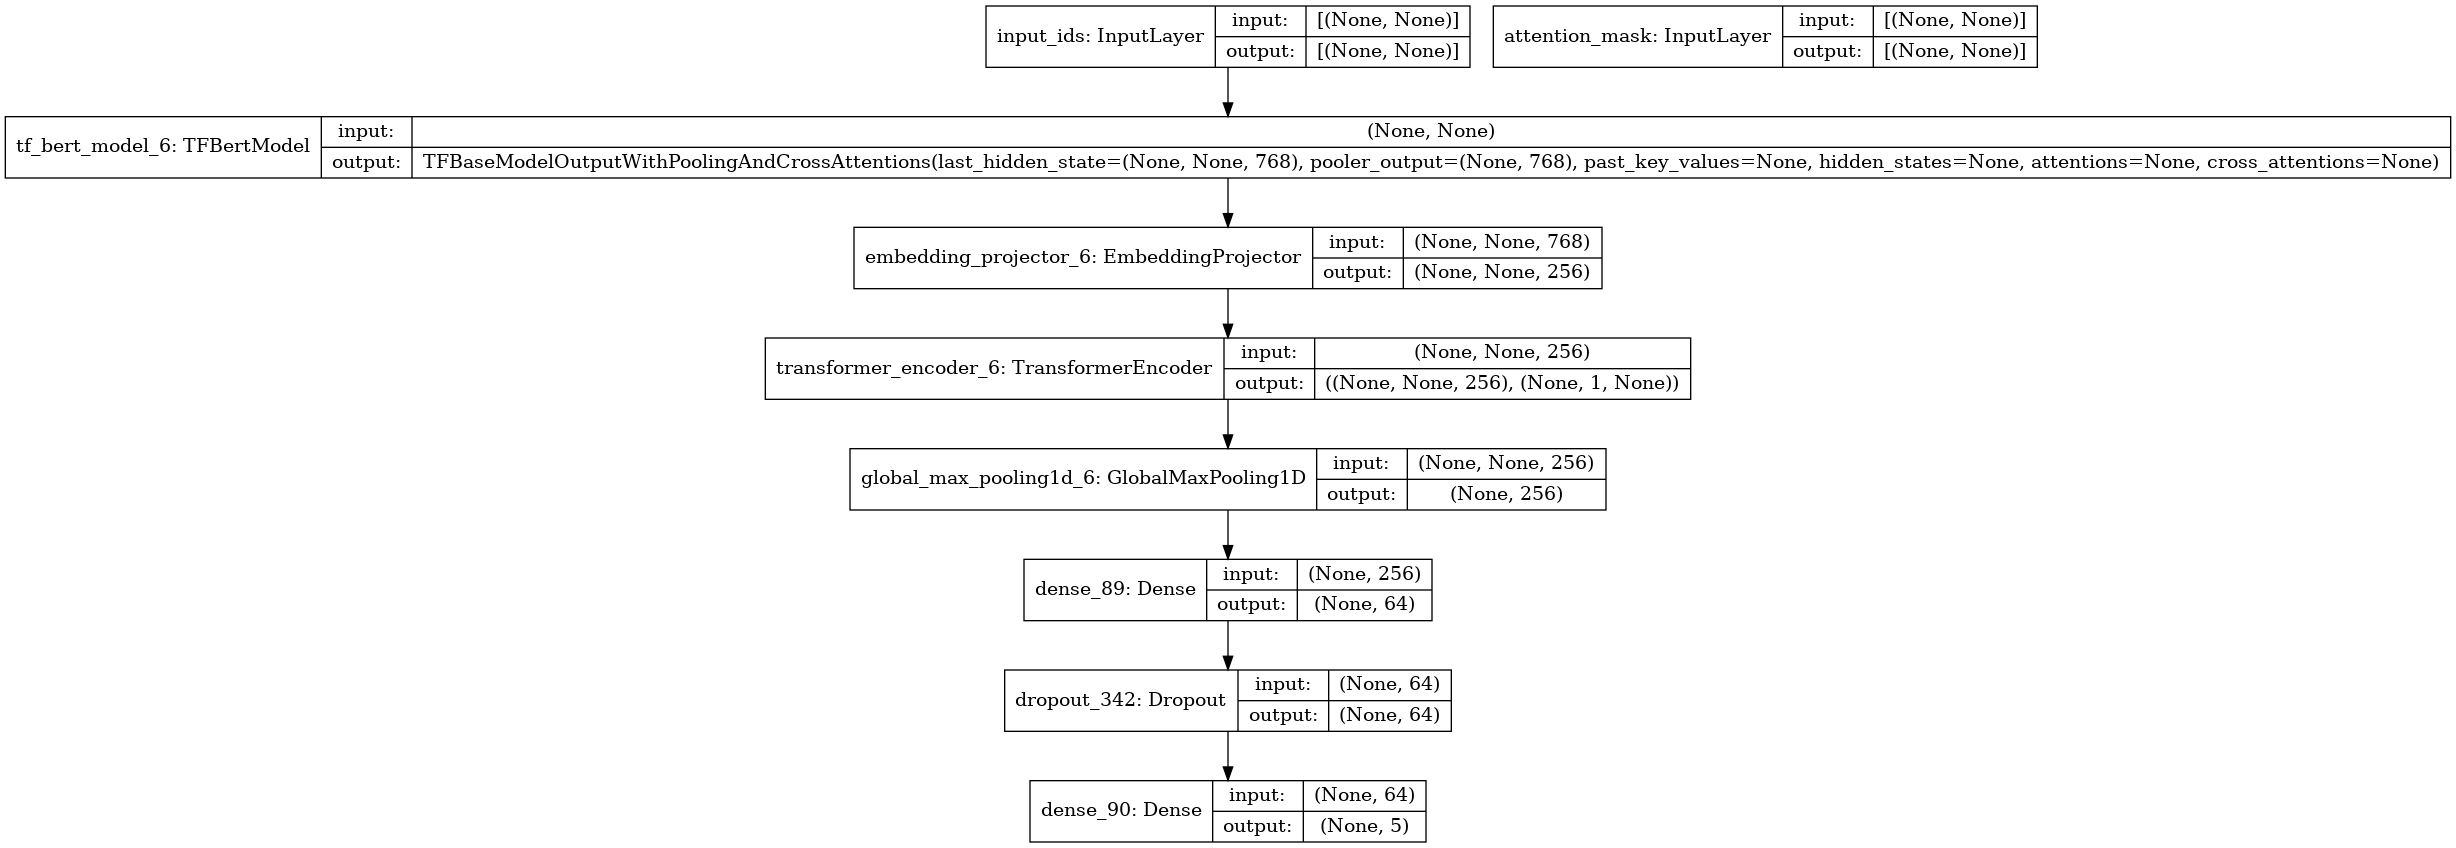

In [45]:
model_name = lang_prefix+f"TransformerEncoder{'BiLSTM' if use_lstm else ''}_{bert_names['inp']}".replace('/', '-')

with strategy.scope():
    
    inp_pretrained_model = TFAutoModel.from_pretrained(**bert_params['inp']) 
    model = BertTransformerEncoder(inp_pretrained_model=inp_pretrained_model, 
                                   num_tune=num_tune, 
                                   num_projection_layers=num_projection_layers, 
                                   use_lstm=use_lstm, 
                                   nn_units=nn_units, 
                                   num_layers=num_layers, 
                                   embed_dim=embed_dim, 
                                   num_heads=num_heads,
                                   dense_dim=dense_dim,
                                   num_classes=num_classes,
                                   activation=activation, 
                                   dropout=dropout)

    print(model_name)
    display(model.build_graph().summary())
    display(tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True))

## <b> 4. Training and checkpointing <b/>

### <b> Checkpoint <b/>

In [46]:
# Record the training configurations as the name of checkpoints, logs and models to compare the different results
run_id  = f"{num_layers}layers_{num_projection_layers}projlayers_{nn_units}nnunits"
run_id += f"_{num_heads}heads_{embed_dim}embedding_{dense_dim}hidden_{dropout}dropout_{activation_name}"
run_id += f"_{init_lr}initlr_{num_warmup_steps}warmup_{optimizer._name}_tune{num_tune}layers"
run_id += f"_{GLOBAL_BATCH_SIZE}batchsize_{BUFFER_SIZE}shuffle_{num_samples}samples"
print('run_id:', run_id, '\n')

# Setup the saving path
checkpoint_path = os.path.join(DIR_CHECKPOINT, model_name+'_'+run_id)
log_dir = os.path.join(DIR_LOG, model_name+'_'+run_id)

# Setup callbacks
es_metric = 'val_loss'

with strategy.scope():
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor=es_metric, save_weights_only=True, save_best_only=True, verbose=1, filepath=checkpoint_path)
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor=es_metric, patience=EARLYSTOP, restore_best_weights=True, verbose=1)
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

    callbacks = [tensorboard, checkpoint, earlystopping]

    # If there are corresponding files, then ckpt will load and restore the status of objects
    try:
        model.load_weights(checkpoint_path)
        print(f'Restore the checkpoint at {checkpoint_path}')
    except:
        print("There is no existed checkpoint ... Start from the beginning.\n")

run_id: 4layers_2projlayers_64nnunits_8heads_256embedding_512hidden_0.2dropout_gelu_78130warmup_AdamWeightDecay_tune0layers_64batchsize_8192shuffle_500000samples 

There is no existed checkpoint ... Start from the beginning.



2021-11-17 16:53:11.957681: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-17 16:53:11.957718: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-17 16:53:11.957931: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


### <b> Training <b/>

In [ ]:
%%time

with strategy.scope():
    
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
    
history = model.fit(train_batches.repeat(EPOCHS), validation_data=valid_batches, 
                    epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

## <b> 5. Model Export & Pipeline Build <b/>

### <b> Evaluation <b/>

In [ ]:
%%time

loss, accuracy = model.evaluate(test_batches)

score = f"accuracy-{accuracy:.6f}-{dataset_name}"
score

### <b> Export <b/>

In [ ]:
### Create and save the predictor

config_detail = f"{model_name}_{score}_{run_id}"
predictor = HF2TFSingleClassifierExporter(model, bert_names, config_detail, num_classes, inp_lang)
predictor_dir = os.path.join(DIR_MODEL, f"{model_name}_{score}")
tf.saved_model.save(predictor, export_dir=predictor_dir)

### Reload the pipeline to verify the result

pretrain_dir = DIR_MODELTORCH
pipeline = HF2TFClassifierPipeline(predictor_dir, pretrain_dir, text_preprocessors)

## <b> 6. Inference <b/>

In [75]:
sentences = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    'this is a bad test', 
    'and happy one is here to be classified',
    'I broke up with my...cat, help me :(:(:(',
    'movie data seems to be not enough',
    'it is definitely not bad'
]

results = pipeline(sentences, max_length=MAX_LENGTHS['inp'])
results_for_printing = [f"Input: {sentences[n]:<50} => score: {results[n][0]:.6f}"
                        for n, text in enumerate(sentences)]

print(*results_for_printing, sep='\n')

Input: this is such an amazing movie!                     => score: 0.198779
Input: The movie was great!                               => score: 0.394043
Input: The movie was meh.                                 => score: 0.277968
Input: The movie was okish.                               => score: 0.264516
Input: The movie was terrible...                          => score: 0.172645
Input: this is a bad test                                 => score: 0.264395
Input: and happy one is here to be classified             => score: 0.445607
Input: I broke up with my...cat, help me :(:(:(           => score: 0.117212
Input: movie data seems to be not enough                  => score: 0.223223
Input: it is definitely not bad                           => score: 0.326945
